In [1]:
## 模型与剖分

import math
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from tool import interfaceData, getIsBdNode, uniform_refine, get_cr_node_cell
from tool import get_A1_A2_F, my_solve, H1Error, print_error, print_P
from tool import get_stiff_and_div_matrix, get_bb, drawer_uh_u
from tool import getCellInOmega

n   = 3  #剖分次数
n   = n + 1 
Lam = np.array([[1e0, 2e0, 3e0, 4e0],
                [1e4, 2e4, 3e4, 4e4],
                [1e8, 2e8, 3e8, 4e8]])

#Lam = np.array([[1e0, 2e0, 3e0, 4e0]])

Mu  = Lam

H     = np.zeros(n)                                  #步长
P     = np.zeros(Lam.shape[0])                       #误差阶
E     = np.zeros((Lam.shape[0],n), dtype=np.float64) #每个lambda(行)对应的误差(列)
 
for i in range(Lam.shape[0]):
    pde = interfaceData(Lam[i], Mu[i])
    node = pde.node
    cell = pde.cell
    for j in range(n):
        NC = cell.shape[0]
        #print("cr_NC= ", NC)
        # nn 特定情况下剖分次数
        nn  = math.log(NC/2, 4)
        NN = int(3 * 2 * 4**nn - (3 * 2 * 4**nn - 4 * 2**nn) / 2)
        cm = np.ones(NC, dtype=np.float64) / NC
     
        cr_node, cr_cell = get_cr_node_cell(node,cell)

        # 单元刚度矩阵和单元载荷向量 
        A1, A2 = get_stiff_and_div_matrix(cr_node, cr_cell, cm)
        bb = get_bb(pde, node, cell, cm)
        cellInOmega = getCellInOmega(cr_node, cr_cell)
        kk = 1
        for k in range(4):
            A1[cellInOmega[k]] *= pde.mu[k]
            A2[cellInOmega[k]] *= pde.mu[k] + pde.lam[k]
        A1, A2, F = get_A1_A2_F(A1, A2, bb, cr_node, cr_cell)
        A = A1 + A2
        """
        whichCell = getWhichCell(cr_node)
        interfaceCell = getInterfaceCell(cr_node)
        #print("interfaceCell= ", interfaceCell)
        phiCell = phiInWhichCell(whichCell)
        interfaceCell = phiInWhichCell(interfaceCell)
        
        A = np.zeros((2 * NN, 2 * NN), dtype=np.float64)
        for k in range(4):
            ii = phiCell[k].reshape(2 * NN, 1)
            jj = phiCell[k].reshape(1,2 * NN)
            tmp_A = pde.mu[k] * A1 + (pde.lam[k] + pde.mu[k]) * A2
            tmp_A = tmp_A.toarray()
            A = np.where(ii * jj, tmp_A * ii *jj, A)
        """
        """
        for k in range(4):
            if k == 0: 
                ii_1 = interfaceCell[0].reshape(2 * NN, 1)
                ii_2 = interfaceCell[2].reshape(2 * NN, 1)
            if k == 1:
                ii_1 = interfaceCell[0].reshape(2 * NN, 1)
                ii_2 = interfaceCell[3].reshape(2 * NN, 1) 
            if k == 2:
                ii_1 = interfaceCell[1].reshape(2 * NN, 1)
                ii_2 = interfaceCell[2].reshape(2 * NN, 1) 
            if k == 3:
                ii_1 = interfaceCell[1].reshape(2 * NN, 1)
                ii_2 = interfaceCell[3].reshape(2 * NN, 1) 
            jj = phiCell[k].reshape(1,2 * NN)
            tmp_A = pde.mu[k] * A1 + (pde.lam[k] + pde.mu[k]) * A2
            tmp_A = tmp_A.toarray()
            A = np.where(ii_1 * jj, tmp_A * ii_1 *jj, A)
            A = np.where(ii_2 * jj, tmp_A * ii_2 *jj, A)
            A = np.where(jj * ii_1, tmp_A * jj * ii_1, A)
            A = np.where(jj * ii_2, tmp_A * jj * ii_2, A)
            A = np.where(ii_1 * ii_2, tmp_A * ii_1 * ii_2, A)
            A = np.where(ii_2 * ii_1, tmp_A * ii_2 * ii_1, A)
        """
        #A = csr_matrix(A)

        """
        ij = 2
        print("phiCell= ", phiCell[ij])
        print("A1= ", A1.toarray()[:, phiCell[ij]][phiCell[ij]])
        print("A2= ", A2.toarray()[:, phiCell[ij]][phiCell[ij]])
        print("A= ", A.toarray()[:, phiCell[ij]][phiCell[ij]])
        """

        uh = my_solve(A, F, cr_node, getIsBdNode)
        u = pde.solution(cr_node, cr_node)
        H[j] = np.sqrt(2 * cm[0]) / 2
        E[i][j] = H1Error(u, uh)
        if j < n-1:
            node, cell = uniform_refine(node, cell)
    drawer_uh_u(cr_node, uh, u, "../../image/tmp/interface_uh_u/uh_lam={}.png".format(Lam[i]), "../../image/tmp/interface_uh_u/u_lam={}.png".format(Lam[i]))

# 画图 得到误差阶
if n-1 > 1: 
    # 画图
    for i in range(len(Lam)):
        fig = plt.figure()
        plt.plot(np.log(H[1:]), np.log(E[i][1:]))
        plt.title("lam={}".format(Lam[i]))
        plt.xlabel("log(h)")
        plt.ylabel("log(e)")
        plt.savefig(fname="interfaceCRFem/elasticityCRFemLam_{}.png"
                    .format(Lam[i]))
        plt.close(fig)
    # 求误差阶 
    # 得到 P
    for i in range(len(Lam)):
        f = np.polyfit(np.log(H[1:]), np.log(E[i][1:]) ,1)
        P[i] = f[0]

print_error(Lam, H, E)
if n-1 > 1:
    print_P(Lam, P)

---------------------Lam= [1. 2. 3. 4.]---------------------

h=  0.25
e= 0.01984010848114573

h=  0.125
e= 0.008447614792503368

h=  0.0625
e= 0.00444684798733844

h=  0.03125
e= 0.002373949308667161


---------------------Lam= [10000. 20000. 30000. 40000.]---------------------

h=  0.25
e= 1.9840108481145726e-06

h=  0.125
e= 8.447614792503367e-07

h=  0.0625
e= 4.4468479873384417e-07

h=  0.03125
e= 2.373949308667164e-07


---------------------Lam= [1.e+08 2.e+08 3.e+08 4.e+08]---------------------

h=  0.25
e= 1.984010848114573e-10

h=  0.125
e= 8.447614792503368e-11

h=  0.0625
e= 4.446847987338438e-11

h=  0.03125
e= 2.3739493086671527e-11


---------------------误差阶---------------------
lam=  [1. 2. 3. 4.]
p=  0.915627460369104

lam=  [10000. 20000. 30000. 40000.]
p=  0.9156274603691028

lam=  [1.e+08 2.e+08 3.e+08 4.e+08]
p=  0.9156274603691115



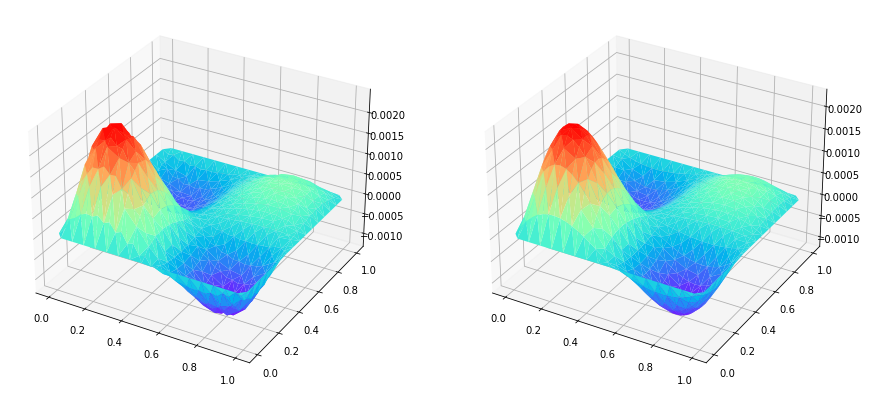

In [8]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

x = cr_node[:,0]
y = cr_node[:,1]
#x, y = np.meshgrid(x, y)
z1 = uh[:,0]
z2 = u[:,0]
#z = np.sin(x) + np.sin(y)

#ax.plot_surface(x,y,z)
ax1.plot_trisurf(x, y, z1, cmap='rainbow')
ax2.plot_trisurf(x, y, z2, cmap='rainbow')

plt.savefig(fname="../../image/tmp/interface_uh_u/uh_u_lam={}.png".format(Lam[i]))

In [2]:
import numpy as np

a = np.array([[1,1,1],
              [2,2,2],
              [3,3,3]], dtype=np.float64)

i = np.array([True, True, False])
i = i.reshape(3,1)
j = i.reshape(1,3)
a = np.where(i * j, a * i * j * 2, a)
print("a= ", a)
print("i * j= ", i * j)
print("j * i= ", j * i)

a=  [[2. 2. 1.]
 [4. 4. 2.]
 [3. 3. 3.]]
i * j=  [[ True  True False]
 [ True  True False]
 [False False False]]
j * i=  [[ True  True False]
 [ True  True False]
 [False False False]]


In [2]:
## 模型与剖分

import math
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from tool import interfaceData, getIsBdNode, uniform_refine, get_cr_node_cell
from tool import get_A1_A2_F, my_solve, error, print_error, print_P
from tool import get_stiff_and_div_matrix, get_bb, getWhichCell, phiInWhichCell
from tool import getInterfaceCell

n   = 3  #剖分次数
n   = n + 1 
Lam = np.array([[1e0, 1e0, 1e0, 1e0]])
Mu  = Lam

H     = np.zeros(n)                                  #步长
P     = np.zeros(Lam.shape[0])                       #误差阶
E     = np.zeros((Lam.shape[0],n), dtype=np.float64) #每个lambda(行)对应的误差(列)
    
for i in range(Lam.shape[0]):
    pde = interfaceData(Lam[i], Mu[i])
    node = pde.node
    cell = pde.cell
    for j in range(n):
        NC = cell.shape[0]
        #print("cr_NC= ", NC)
        # nn 特定情况下剖分次数
        nn  = math.log(NC/2, 4)
        NN = int(3 * 2 * 4**nn - (3 * 2 * 4**nn - 4 * 2**nn) / 2)
        cm = np.ones(NC, dtype=np.float64) / NC
     
        cr_node, cr_cell = get_cr_node_cell(node,cell)
        #print("cr_node= ", cr_node.shape[0])
        #print("cr_cell= ", cr_cell.shape[0])

        # 单元刚度矩阵和单元载荷向量 
        A1, A2 = get_stiff_and_div_matrix(cr_node, cr_cell, cm)
        bb = get_bb(pde, node, cell, cm)
        
        A1, A2, F = get_A1_A2_F(A1, A2, bb, cr_node, cr_cell)
        A = A1 + 2 * A2
              
        uh = my_solve(A, F, cr_node, getIsBdNode)
        u = pde.solution(cr_node, cr_node)
        H[j] = np.sqrt(2 * cm[0])
        #print("h= ", np.sqrt(2 * cm[0]))
        # 计算误差
        E[i][j] = error(u, uh)
        #E[i][j] = H_1_norm(u-uh, H[j])
        #print("u= ", u)
        #print("uh= ", uh)
        node, cell = uniform_refine(node, cell)

if n-1 > 1: 
    for i in range(len(Lam)):
        fig = plt.figure()
        plt.plot(np.log(H[1:]), np.log(E[i][1:]))
        plt.title("lam={}".format(Lam[i]))
        plt.xlabel("log(h)")
        plt.ylabel("log(e)")
        plt.savefig(fname="interfaceCRFem/elasticityCRFemLam_{}.png"
                    .format(Lam[i]))
        plt.close(fig)
        
    for i in range(len(Lam)):
        f = np.polyfit(np.log(H[1:]), np.log(E[i][1:]) ,1)
        P[i] = f[0]

#print("u= ", np.max(u))
#print("uh= ", np.max(uh))
print_error(Lam, H, E)
#print_error(Lam, H, E[isInterNode], E_rel[isInterNode])
if n-1 > 1:
    print_P(Lam, P)

---------------------Lam= [1. 1. 1. 1.]---------------------

h=  0.5
e= 0.07987830915813868

h=  0.25
e= 0.02032619658318343

h=  0.125
e= 0.005805449467439612

h=  0.0625
e= 0.001580892771167331


---------------------误差阶---------------------
lam=  [1. 1. 1. 1.]
p=  1.8422644319317023

